## Questions:
---
    1. what are the hyper parameters you can tune?
    2. Tune the models so that the latent distribution is more compact (add layers to the encoder and the decoder)
    3. How well can we actually use this to generate new samples (sequences of hiv clinical subtypes not in the dataset?). State your conclusions, and reason why this is or is not a viable approach

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from tensorflow.keras import backend as K

from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.datasets import mnist


original_dim = 8000
intermediate_dim = 512
latent_dim = 2
batch_size = 100
epochs = 100
epsilon_std = 1.0


In [46]:

def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs



In [47]:
decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input(tensor=K.random_normal(stddev=epsilon_std,
                                   shape=(K.shape(x)[0], latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

x_pred = decoder(z)

vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=nll)


In [48]:
import pandas as pd
import glob
from sklearn.model_selection import train_test_split


In [49]:
def splitw(x):
    return np.array([y for y in x])
#.replace('T','1'),replace('G','2').replace('C','3')

In [50]:
FILES=glob.glob('../../datasets/SEQUENCE_/HIV/*seq')
#! wc ../hwdata/hiv/*seq

In [51]:
data=pd.concat([pd.read_csv(i,header=None) for i in FILES])

data1=np.array([x for x in np.squeeze(data)])

data2=np.array([splitw(x.replace('A','1').replace('T','2').replace('G','3').replace('C','4')).astype(int) for x in data1])

data2.shape

(158,)

In [52]:
data2[0].shape

(9646,)

In [53]:
X=[]
dim1=158
for i in data2:
    X=np.append(X,i[:original_dim])
X=X.reshape(dim1,int(original_dim))
X=X/4.

In [54]:
y=np.array([0*np.ones(60),1*np.ones(37),2*np.ones(23),3*np.ones(38)])
y=np.squeeze(y)
YY=[]
for i in y:
    YY=np.append(YY,i)
YY

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3.])

In [55]:
x_train, x_test, y_train,  y_test=train_test_split(X,YY,test_size=.2)

In [56]:
x_test.shape

(32, 8000)

In [57]:
vae.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 8000)]       0                                            
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 512)          4096512     input_9[0][0]                    
__________________________________________________________________________________________________
dense_23 (Dense)                (None, 2)            1026        dense_22[0][0]                   
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 2)            1026        dense_22[0][0]                   
____________________________________________________________________________________________

In [58]:
vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

encoder = Model(x, z_mu)

Train on 126 samples, validate on 32 samples
Epoch 1/100
126/126 [==============================] - 1s 6ms/sample - loss: 8871.9310 - val_loss: 7925.0264
Epoch 2/100
126/126 [==============================] - 0s 996us/sample - loss: 7591.1393 - val_loss: 5995.0430
Epoch 3/100
126/126 [==============================] - 0s 967us/sample - loss: 5914.5871 - val_loss: 5574.0669
Epoch 4/100
126/126 [==============================] - 0s 950us/sample - loss: 5569.4338 - val_loss: 5562.7607
Epoch 5/100
126/126 [==============================] - 0s 949us/sample - loss: 5554.1320 - val_loss: 5549.0454
Epoch 6/100
126/126 [==============================] - 0s 991us/sample - loss: 5540.0595 - val_loss: 5543.0146
Epoch 7/100
126/126 [==============================] - 0s 975us/sample - loss: 5532.7815 - val_loss: 5567.4614
Epoch 8/100
126/126 [==============================] - 0s 952us/sample - loss: 5555.8810 - val_loss: 5554.1265
Epoch 9/100
126/126 [==============================] - 0s 963us/sampl

Epoch 74/100
126/126 [==============================] - 0s 949us/sample - loss: 5434.8159 - val_loss: 5421.6274
Epoch 75/100
126/126 [==============================] - 0s 948us/sample - loss: 5407.1718 - val_loss: 5408.3257
Epoch 76/100
126/126 [==============================] - 0s 996us/sample - loss: 5404.5880 - val_loss: 5407.0688
Epoch 77/100
126/126 [==============================] - 0s 988us/sample - loss: 5397.7860 - val_loss: 5486.3262
Epoch 78/100
126/126 [==============================] - 0s 939us/sample - loss: 5533.9653 - val_loss: 5468.6362
Epoch 79/100
126/126 [==============================] - 0s 951us/sample - loss: 5464.1481 - val_loss: 5642.6992
Epoch 80/100
126/126 [==============================] - 0s 939us/sample - loss: 5599.7261 - val_loss: 5422.8457
Epoch 81/100
126/126 [==============================] - 0s 966us/sample - loss: 5409.4685 - val_loss: 5408.3115
Epoch 82/100
126/126 [==============================] - 0s 933us/sample - loss: 5396.4542 - val_loss: 54

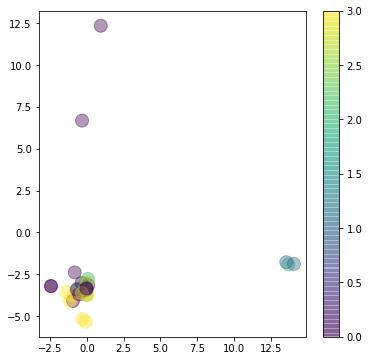

In [59]:
# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=13**2, cmap='viridis')
plt.colorbar()


In [ ]:
val=[4,.5]

In [ ]:
''.join(np.round(decoder.predict(np.array(val).reshape(1,2))*4)[0].astype(int).astype(str)).replace('1','A').replace('2','T').replace('3','G').replace('4','C')

In [ ]:
val=[.5,.5]

In [ ]:
''.join(np.round(decoder.predict(np.array(val).reshape(1,2))*4)[0].astype(int).astype(str)).replace('1','A').replace('2','T').replace('3','G').replace('4','C')